In [ ]:
import xarray as xr
import numpy as np
import warnings 
import netCDF4
from netCDF4 import Dataset

import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define functions

In [10]:
#Set constant
EARTH_RADIUS_METERS = 6.371e6
def _calculate_spherical_grid_areas(lat_edges, lon_edges, R=EARTH_RADIUS_METERS):
    """
    Calculates the area of each grid cell on a sphere.
    Formula: R^2 * (lon2 - lon1) * (sin(lat2) - sin(lat1))
    Lat/Lon edges should be in degrees. Output area in m^2.
    """
    lon_rad = np.deg2rad(lon_edges)
    lat_rad = np.deg2rad(lat_edges)

    d_lon = np.diff(lon_rad)[np.newaxis, :]
    sin_lat2_minus_sin_lat1 = np.diff(np.sin(lat_rad))[:, np.newaxis]

    areas = (R**2) * d_lon * sin_lat2_minus_sin_lat1
    return areas
    
def initialize_regridding(DataHD): #Data formatting rules apply!! 
    #Takes in a half-degree (only!) xarray.DataArray gridded variable in the form DataHD.var_name, and returns it regridded to the irregular GeosChem 4x5 grid
    #input lat/lon dimensions must be called "latitude" and "longitude" 
    #input lat/lon dimensions must be given in degrees (i.e. -179.75, -179.25, etc., no numerical index like 0, 1, 2, etc.)
    #It is assumed that half degree coordinates are pixel centers
    #It is assumed that input half-degree per-area data are defined relatieve to whole pixel area; 
    #In contrast, Output 4x5 per-area data will be defined relative to the area of the mask of contributing half-degree pixels; approximately per pixel land-only area     

    req_dims = ['latitude', 'longitude']
    for d in req_dims:
        if d not in DataHD.dims:
            raise ValueError(f"Input data must have dimension '{d}'")

    other_dims = [d for d in DataHD.dims if d not in req_dims]
    other_coords = {d: DataHD.coords[d] for d in other_dims}

    var_name = DataHD.name
    if var_name is None:
        raise ValueError("Input DataArray must have a name (e.g., `DataHD.name`).")

    lon_res = 5.0
    lat_res = 4.0
    lon_centers = np.arange(-180, 180, 5) 
    lon_edges = np.concatenate(([lon_centers[0] - lon_res / 2], lon_centers + lon_res / 2))
    lat_centers = np.array([-89.] + list(np.arange(-86, 86+1, 4)) + [89.])
    core_edges_4deg = np.arange(-88, 88 + 4, 4)
    lat_edges = np.concatenate(([-90.0], core_edges_4deg, [90.0]))
    Areas4x5=_calculate_spherical_grid_areas(lat_edges, lon_edges, R=EARTH_RADIUS_METERS)
    
    Areas4x52 = xr.Dataset(
        data_vars=dict(
            Areas4x5=(['latitude', 'longitude'], Areas4x5)
        ),
        coords=dict(
            latitude=lat_centers,
            longitude=lon_centers
        )
    )
    
    lon_res = 0.5
    lat_res = 0.5
    lon_centers = DataHD.longitude.data 
    lon_edges = np.concatenate(([lon_centers[0] - lon_res / 2], lon_centers + lon_res / 2))
    lat_centers = DataHD.latitude.data
    lat_edges = np.concatenate(([lat_centers[0] - lat_res / 2], lat_centers + lat_res / 2))
    
    AreasHD=_calculate_spherical_grid_areas(lat_edges, lon_edges, R=EARTH_RADIUS_METERS)
    
    AreasHD2 = xr.Dataset(
        data_vars=dict(
            AreasHD=(['latitude', 'longitude'], AreasHD)
        ),
        coords=dict(
            latitude=DataHD.latitude.data,
            longitude=DataHD.longitude.data
        )
    )
    
    target_lat = Areas4x52.latitude
    target_lon = Areas4x52.longitude
    target_area = Areas4x52.Areas4x5
    coords = {'latitude': target_lat, 'longitude': target_lon}
    coords.update(other_coords)
    shape = (len(target_lat), len(target_lon)) + tuple(len(other_coords[d]) for d in other_dims)
    
    
    # Create an nD DataArray filled with NaNs: (other_dims (e.g. time), latitude, longitude)

    data_regridded = xr.DataArray(
        data=np.full(shape, np.nan),
        coords=coords,
        dims=['latitude', 'longitude'] + other_dims
    )

    contributing_area = xr.full_like(target_area, fill_value=np.nan)

    # Create dataset to hold both variables
    data4x5 = xr.Dataset({
        var_name: data_regridded,
        f'contributing_area_{var_name}': contributing_area
    })

    return data4x5, Areas4x52,AreasHD2

def regridding05x05to4x5(DataHD):#Data formatting rules apply!! 
    #Takes in a half-degree (only!) xarray.DataArray gridded variable in the form DataHD.var_name, and returns it regridded to the irregular GeosChem 4x5 grid
    #input lat/lon dimensions must be called "latitude" and "longitude" 
    #input lat/lon dimensions must be given in degrees (i.e. -179.75, -179.25, etc., no numerical index like 0, 1, 2, etc.)
    #It is assumed that half degree coordinates are pixel centers
    #It is assumed that input half-degree per-area data are defined relative to whole pixel area; 
    #In contrast, Output 4x5 per-area data will be defined relative to the area of the mask of contributing half-degree pixels; approximately per pixel land-only area     
    
    data4x5, Areas4x52,AreasHD2 = initialize_regridding(DataHD)
    non_spatial_dims = [d for d in DataHD.dims if d not in ['latitude', 'longitude']]
    subset_two_poles=(DataHD*AreasHD2.AreasHD)[dict(latitude=np.concatenate([np.arange(4), np.arange(356,360)]))]
    subset_middle=(DataHD*AreasHD2.AreasHD)[dict(latitude=np.arange(4,356))]

    TotalmassHD=DataHD*AreasHD2.AreasHD
    
    for i in subset_two_poles.latitude[::4].data: 
        lat_idx=np.where(subset_two_poles.latitude==i)[0][0]
        #print(i,lat_idx)
        lat_range=subset_two_poles.latitude[np.arange(lat_idx,lat_idx+4)]
        #print(lat_range.data)
    
        for j in subset_two_poles.longitude[5:][::10].data:
            if j == subset_two_poles.longitude[5:][::10][-1]:
                #print('wrapping longitude:')
                lon_range=subset_two_poles.longitude.data[np.r_[0:5, 715:720]]  
                lon4x5=-180.0
                #print(lon4x5)
            else:
                lon_idx=np.where(subset_two_poles.longitude==j)[0][0]
                # print(j,lon_idx)
                lon_range=subset_two_poles.longitude[np.arange(lon_idx,lon_idx+10)]
                #print(lon_range.data)
                lon4x5=lon_range.data.mean()
                #print(lon4x5)
    
            #Select data
            data_temp=DataHD[dict(latitude=np.where(DataHD.latitude.isin(lat_range))[0],
                                      longitude=np.where(DataHD.longitude.isin(lon_range))[0])].astype('float64')
            areas_temp=AreasHD2.AreasHD[dict(latitude=np.where(DataHD.latitude.isin(lat_range))[0],
                                      longitude=np.where(DataHD.longitude.isin(lon_range))[0])].astype('float64')
            datasum=(data_temp*areas_temp).sum('latitude').sum('longitude')
            #print(areas_temp.sum('latitude').sum('longitude').data)
            areasum=areas_temp.where(~np.isnan(data_temp.mean(dim=non_spatial_dims))).sum('latitude').sum('longitude').data
            #print(areasum)
    
            if areasum == 0:
                # In case of no data:
                regridded_value = datasum * np.nan
            else:
                regridded_value = datasum / areasum # This division results in a scalar or DataArray

            # Set up flexible xarray assignment (step 1)
            var_name = list(data4x5.data_vars)[0]
            contributing_area_name = list(data4x5.data_vars)[1]
            
            lat4x5=lat_range.data.mean()
            #print(lat4x5)
            lat4x5_idx=np.where(data4x5.latitude==lat4x5)[0][0]
            lon4x5_idx=np.where(data4x5.longitude==lon4x5)[0][0]
            #print(lat4x5_idx,lon4x5_idx)
            
            # Set up flexible xarray assignment (step 2)
            loc_dict = {dim: data4x5.coords[dim] for dim in non_spatial_dims} # Get actual coords from data4x5
            loc_dict['latitude'] = lat4x5
            loc_dict['longitude'] = lon4x5

            # Assign directly. Xarray handles the dimensionality of 'regridded_value' correctly.
            data4x5[list(data4x5.data_vars)[0]].loc[loc_dict] = regridded_value
            data4x5[list(data4x5.data_vars)[1]][dict(latitude=lat4x5_idx, longitude=lon4x5_idx)] = areasum
    
    for i in subset_middle.latitude[::8].data: 
        lat_idx=np.where(subset_middle.latitude==i)[0][0]
        #print(i,lat_idx)
        lat_range=subset_middle.latitude[np.arange(lat_idx,lat_idx+8)]
        #print(lat_range.data)
    
        for j in subset_middle.longitude[5:][::10].data:
            if j == subset_middle.longitude[5:][::10][-1]:
                #print('wrapping longitude:')
                lon_range=subset_middle.longitude.data[np.r_[0:5, 715:720]]  
                lon4x5=-180.0
                #print(lon4x5)
            else:
                lon_idx=np.where(subset_middle.longitude==j)[0][0]
                #print(j,lon_idx)
                lon_range=subset_middle.longitude[np.arange(lon_idx,lon_idx+10)]
                #print(lon_range.data)
                lon4x5=lon_range.data.mean()
                #print(lon4x5)
    
            #Select data
            data_temp=DataHD[dict(latitude=np.where(DataHD.latitude.isin(lat_range))[0],
                                      longitude=np.where(DataHD.longitude.isin(lon_range))[0])].astype('float64')
            areas_temp=AreasHD2.AreasHD[dict(latitude=np.where(DataHD.latitude.isin(lat_range))[0],
                                      longitude=np.where(DataHD.longitude.isin(lon_range))[0])].astype('float64')
            datasum=(data_temp*areas_temp).sum('latitude').sum('longitude')
            #print(areas_temp.sum('latitude').sum('longitude').data)
            areasum=areas_temp.where(~np.isnan(data_temp.mean(dim=non_spatial_dims))).sum('latitude').sum('longitude').data
            #print(areasum)

            if areasum == 0:
                # In case of no data:
                regridded_value = datasum * np.nan
            else:
                regridded_value = datasum / areasum # This division results in a scalar or DataArray

            # Set up flexible xarray assignment (step 1)
            var_name = list(data4x5.data_vars)[0]
            contributing_area_name = list(data4x5.data_vars)[1]
            
            lat4x5=lat_range.data.mean()
            #print(lat4x5)
            lat4x5_idx=np.where(data4x5.latitude==lat4x5)[0][0]
            lon4x5_idx=np.where(data4x5.longitude==lon4x5)[0][0]
            #print(lat4x5_idx,lon4x5_idx)
            
            # Set up flexible xarray assignment (step 2)
            loc_dict = {dim: data4x5.coords[dim] for dim in non_spatial_dims} # Get actual coords from data4x5
            loc_dict['latitude'] = lat4x5
            loc_dict['longitude'] = lon4x5

            # Assign directly. Xarray handles the dimensionality of 'regridded_value' correctly.
            data4x5[list(data4x5.data_vars)[0]].loc[loc_dict] = regridded_value
            data4x5[list(data4x5.data_vars)[1]][dict(latitude=lat4x5_idx, longitude=lon4x5_idx)] = areasum

    print('Mass conservation checks: ')
    print('HD mass computed='+str(TotalmassHD.sum('latitude').sum('longitude').sum(dim=non_spatial_dims).data))
    print('4x5 mass='+str((data4x5[list(data4x5.data_vars)[0]]*data4x5[list(data4x5.data_vars)[1]]).sum('latitude').sum('longitude').sum(dim=non_spatial_dims).data))
    
    return(data4x5)

# Unit test

In [12]:
Total_prec=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_TOTAL_PREC_2001-2024.nc').transpose('latitude','longitude','time')
unit_test=xr.load_dataset('/Users/bilir/Downloads/Random_field_regridding_test.nc').rename({'lat':'latitude','lon':'longitude'})
unit_test['latitude']=Total_prec.latitude.data
unit_test['longitude']=Total_prec.longitude.data
unittest4x5=regridding05x05to4x5(unit_test.DATA05x05)

Mass conservation checks: 
HD mass computed=5335206026981289.0
4x5 mass=5335206026981289.0


In [58]:
data4x5, Areas4x52,AreasHD2 = initialize_regridding(unit_test.DATA05x05)

# Precip 

In [13]:
Total_prec=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_TOTAL_PREC_2001-2024.nc').transpose('latitude','longitude','time')

In [14]:
Prec4x5=regridding05x05to4x5(Total_prec.PREC)

Mass conservation checks: 
HD mass computed=9.431154300106944e+16
4x5 mass=9.431154300106944e+16


Text(0.5, 1.0, 'new Precip new regridder v2, 2001-2024 mean')

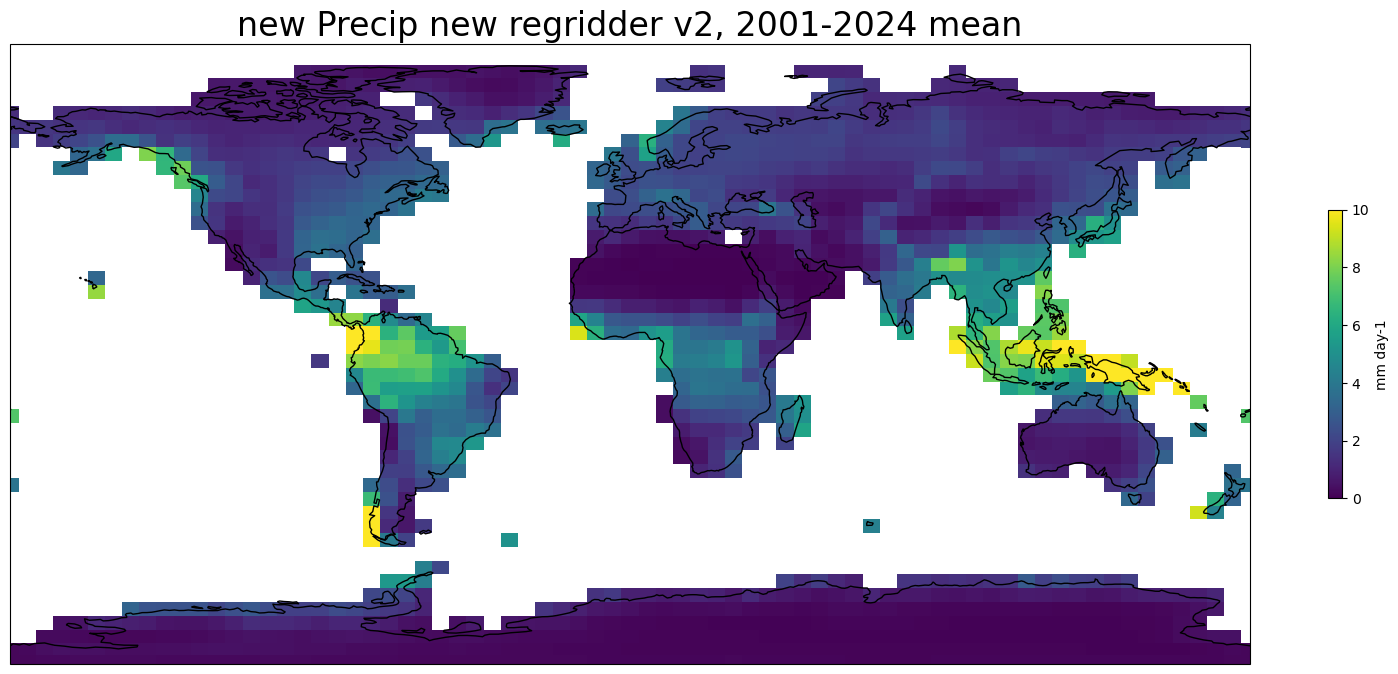

In [15]:
fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data=(Prec4x5['PREC']).mean('time')

C = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())
C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15,label='mm day-1')
plt.title('new Precip new regridder v2, 2001-2024 mean',fontsize=24)

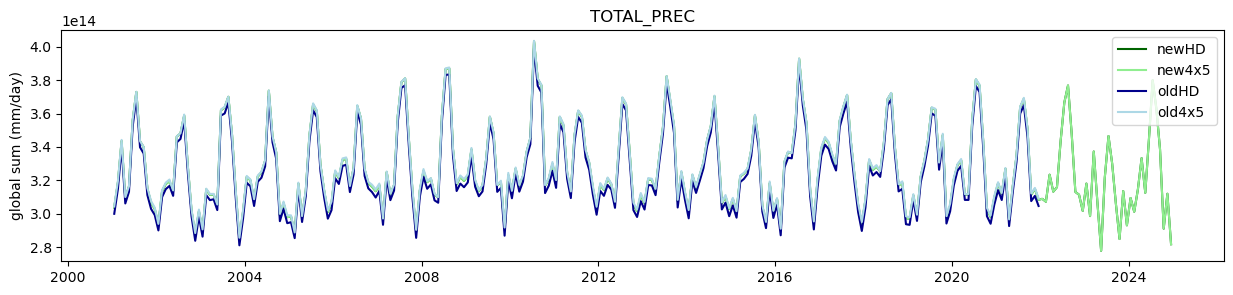

In [63]:
plt.figure(figsize=(15,3))
old_prec=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/TOTAL_PREC_2001-2021.nc')
old_prec4x5=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/PREC.nc')
plt.plot(Total_prec.time,(Total_prec.PREC*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='newHD',color='darkgreen')
plt.plot(Prec4x5.time,(Prec4x5.PREC*Prec4x5.contributing_area_PREC).sum('latitude').sum('longitude'),label='new4x5',color='lightgreen')
plt.plot(old_prec.time,(old_prec.PREC*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='oldHD',color='darkblue')
plt.plot(old_prec.time,(old_prec4x5.PREC*Prec4x5.contributing_area_PREC).sum('latitude').sum('longitude'),label='old4x5',color='lightblue')
plt.title('TOTAL_PREC')
plt.ylabel('global sum (mm/day)')
plt.legend()

In [21]:
Prec4x5.to_netcdf('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/ERA5_4x5TOTAL_PREC_2001-2024.nc')

# TMIN 

In [19]:
TMIN=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_T2MMIN_2001-2024.nc').transpose('latitude','longitude','time')

In [20]:
TMIN4x5=regridding05x05to4x5(TMIN.TMIN)

Mass conservation checks: 
HD mass computed=2.4662361647666877e+17
4x5 mass=2.466236164766688e+17


Text(0.5, 1.0, 'new TMIN new regridder v2, 2001-2024 mean')

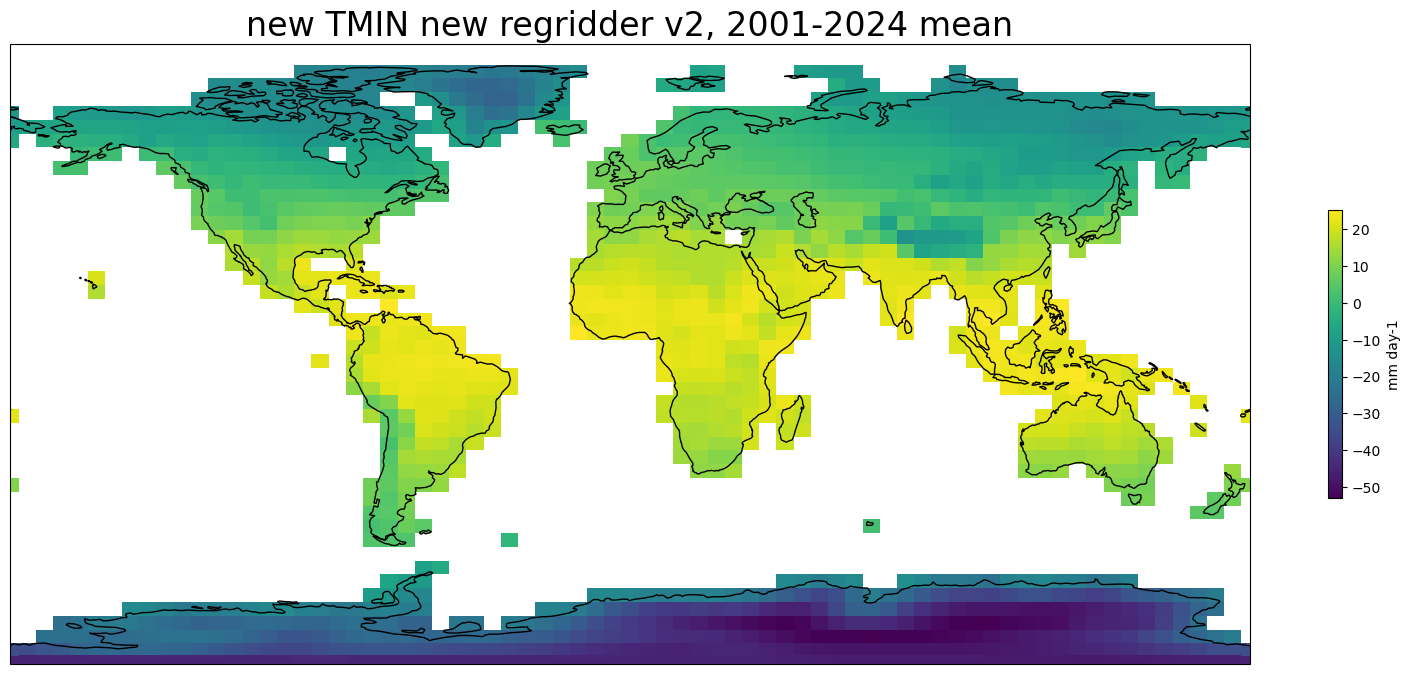

In [23]:
fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data=(TMIN4x5['TMIN']).mean('time')

C = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())
# C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15,label='mm day-1')
plt.title('new TMIN new regridder v2, 2001-2024 mean',fontsize=24)

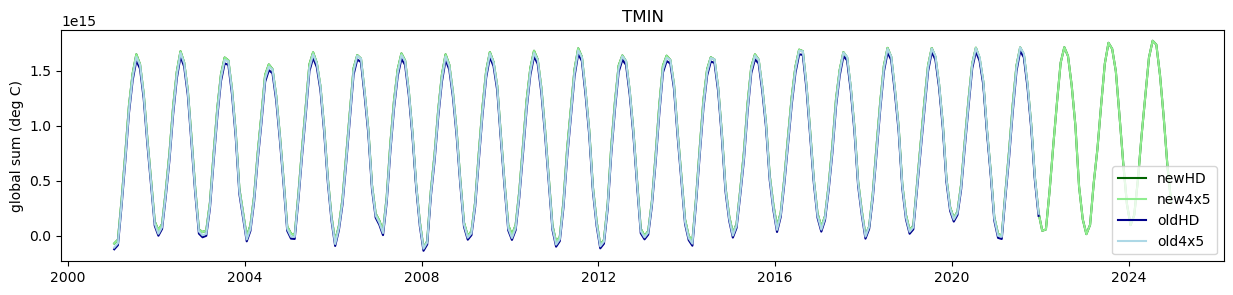

In [64]:
plt.figure(figsize=(15,3))
old_tmin=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_T2MMIN_2001-2021.nc')
old_tmin4x5=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/TMIN.nc')
plt.plot(TMIN.time,(TMIN.TMIN*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='newHD',color='darkgreen')
plt.plot(TMIN4x5.time,(TMIN4x5.TMIN*TMIN4x5.contributing_area_TMIN).sum('latitude').sum('longitude'),label='new4x5',color='lightgreen')
plt.plot(old_tmin.time,(old_tmin.TMIN*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='oldHD',color='darkblue')
plt.plot(old_tmin.time,(old_tmin4x5.TMIN*Prec4x5.contributing_area_PREC).sum('latitude').sum('longitude'),label='old4x5',color='lightblue')
plt.title('TMIN')
plt.ylabel('global sum (deg C)')
plt.legend()

In [24]:
TMIN4x5.to_netcdf('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/ERA5_4x5T2M_MIN_2001-2024.nc')

# TMAX

In [25]:
TMAX=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_T2MMAX_2001-2024.nc').transpose('latitude','longitude','time')

In [27]:
TMAX4x5=regridding05x05to4x5(TMAX.TMAX)

Mass conservation checks: 
HD mass computed=5.98907387761096e+17
4x5 mass=5.98907387761096e+17


Text(0.5, 1.0, 'new TMAX new regridder v2, 2001-2024 mean')

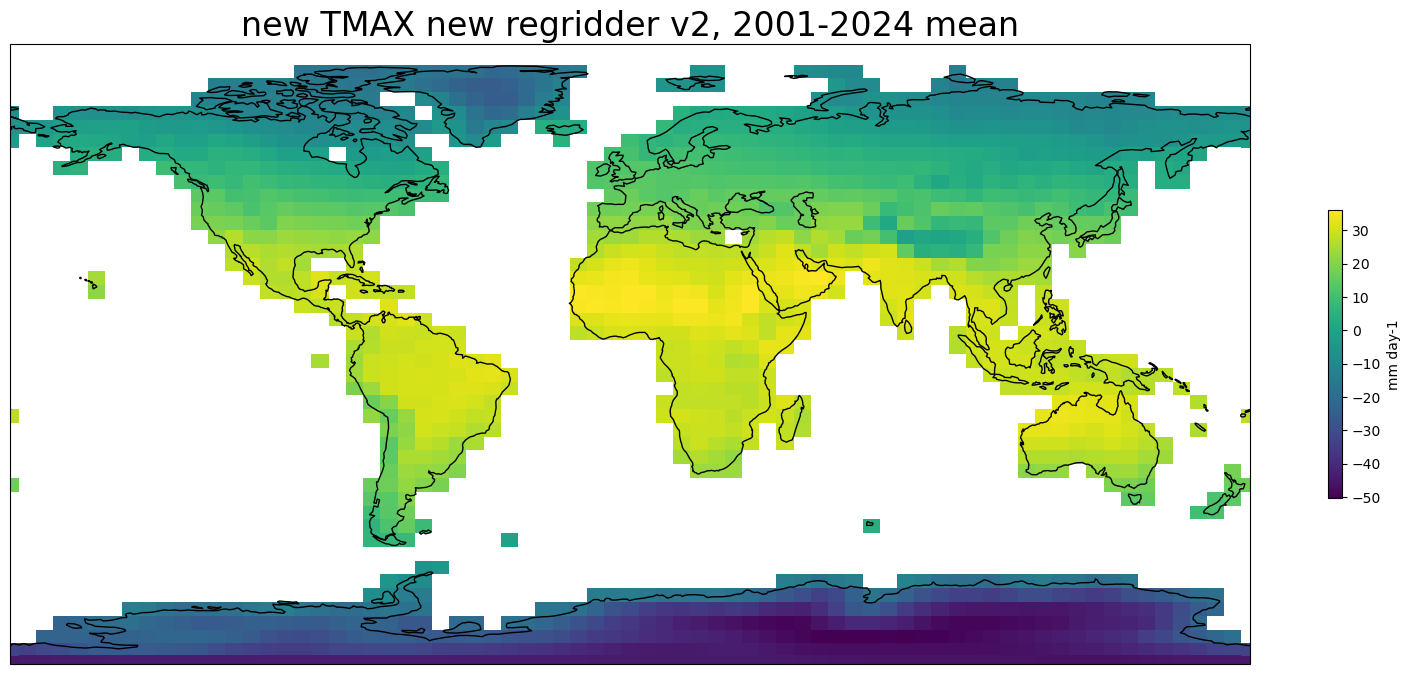

In [28]:
fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data=(TMAX4x5.TMAX).mean('time')

C = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())
# C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15,label='mm day-1')
plt.title('new TMAX new regridder v2, 2001-2024 mean',fontsize=24)

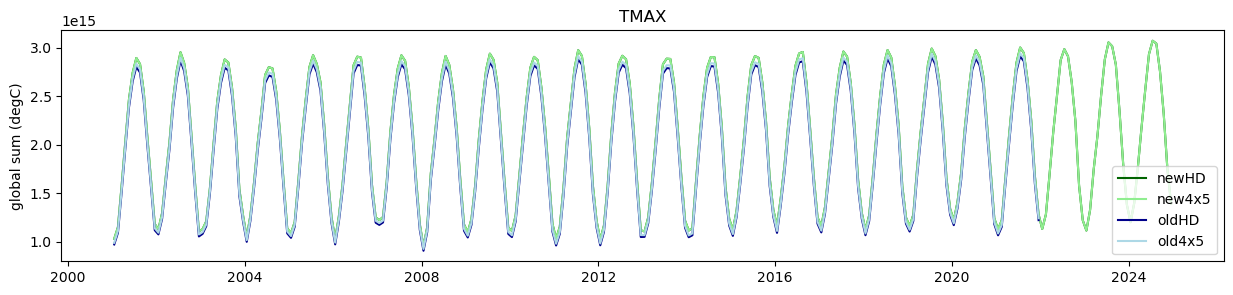

In [67]:
plt.figure(figsize=(15,3))
old_tmax=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_T2MMAX_2001-2021.nc')
old_tmax4x5=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/TMAX.nc')
plt.plot(TMAX.time,(TMAX.TMAX*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='newHD',color='darkgreen')
plt.plot(TMAX4x5.time,(TMAX4x5.TMAX*TMAX4x5.contributing_area_TMAX).sum('latitude').sum('longitude'),label='new4x5',color='lightgreen')
plt.plot(old_tmax.time,(old_tmax.TMAX*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='oldHD',color='darkblue')
plt.plot(old_tmax.time,(old_tmax4x5.TMAX*TMAX4x5.contributing_area_TMAX).sum('latitude').sum('longitude'),label='old4x5',color='lightblue')
plt.title('TMAX')
plt.ylabel('global sum (degC)')
plt.legend()

In [29]:
TMAX.to_netcdf('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/ERA5_4x5T2M_MAX_2001-2024.nc')

# SKT

In [30]:
SKT=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_SKT_2001-2024.nc').transpose('latitude','longitude','time')

In [31]:
SKT4x5=regridding05x05to4x5(SKT.SKT)

Mass conservation checks: 
HD mass computed=4.169280036171263e+17
4x5 mass=4.1692800361712634e+17


Text(0.5, 1.0, 'new SKT new regridder v2, 2001-2024 mean')

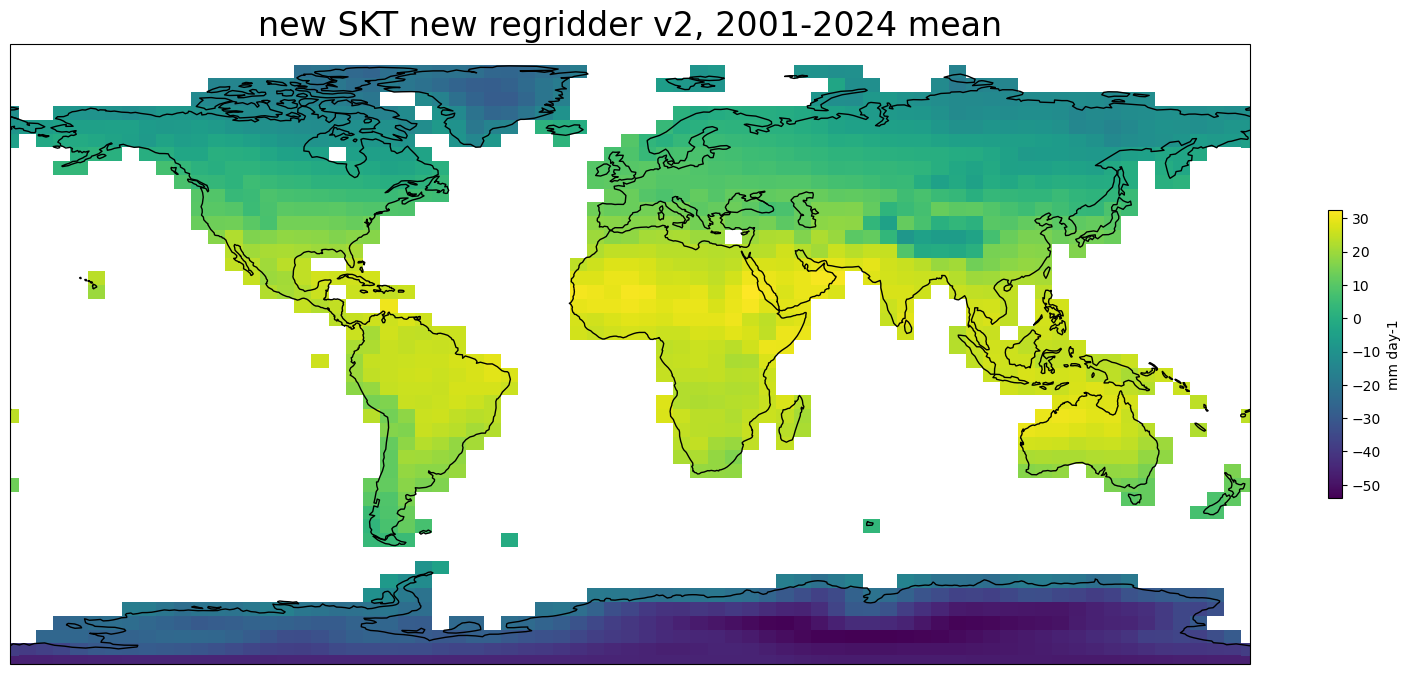

In [32]:
fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data=(SKT4x5.SKT).mean('time')

C = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())
# C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15,label='mm day-1')
plt.title('new SKT new regridder v2, 2001-2024 mean',fontsize=24)

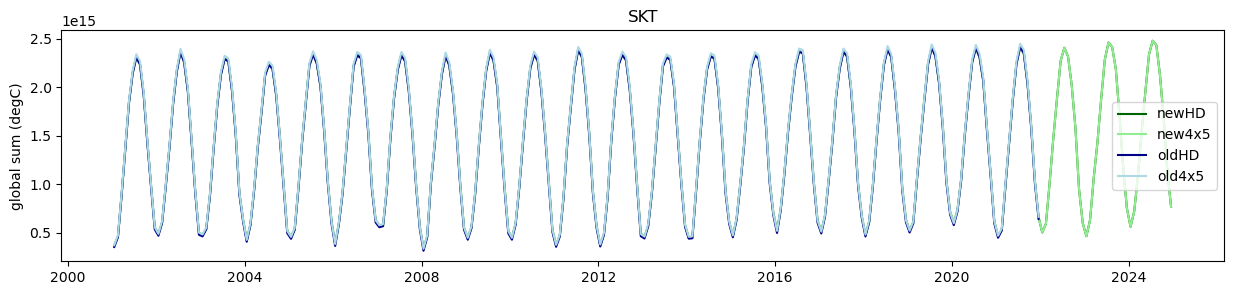

In [68]:
plt.figure(figsize=(15,3))
old_skt=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_SKT_2001-2021.nc')
old_skt4x5=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/SKT.nc')
plt.plot(SKT.time,(SKT.SKT*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='newHD',color='darkgreen')
plt.plot(SKT4x5.time,(SKT4x5.SKT*SKT4x5.contributing_area_SKT).sum('latitude').sum('longitude'),label='new4x5',color='lightgreen')
plt.plot(old_skt.time,(old_skt.SKT*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='oldHD',color='darkblue')
plt.plot(old_skt.time,(old_skt4x5.SKT*SKT4x5.contributing_area_SKT).sum('latitude').sum('longitude'),label='old4x5',color='lightblue')
plt.title('SKT')
plt.ylabel('global sum (degC)')
plt.legend()

In [33]:
SKT.to_netcdf('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/ERA5_4x5SKT_2001-2024.nc')

# SNOWFALL

In [34]:
SNOW=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_SNOW_2001-2024.nc').transpose('latitude','longitude','time')

In [35]:
SNOW4x5=regridding05x05to4x5(SNOW.SNOW)

Mass conservation checks: 
HD mass computed=1.1261905232201426e+16
4x5 mass=1.1261905232201426e+16


Text(0.5, 1.0, 'new SNOW new regridder v2, 2001-2024 mean')

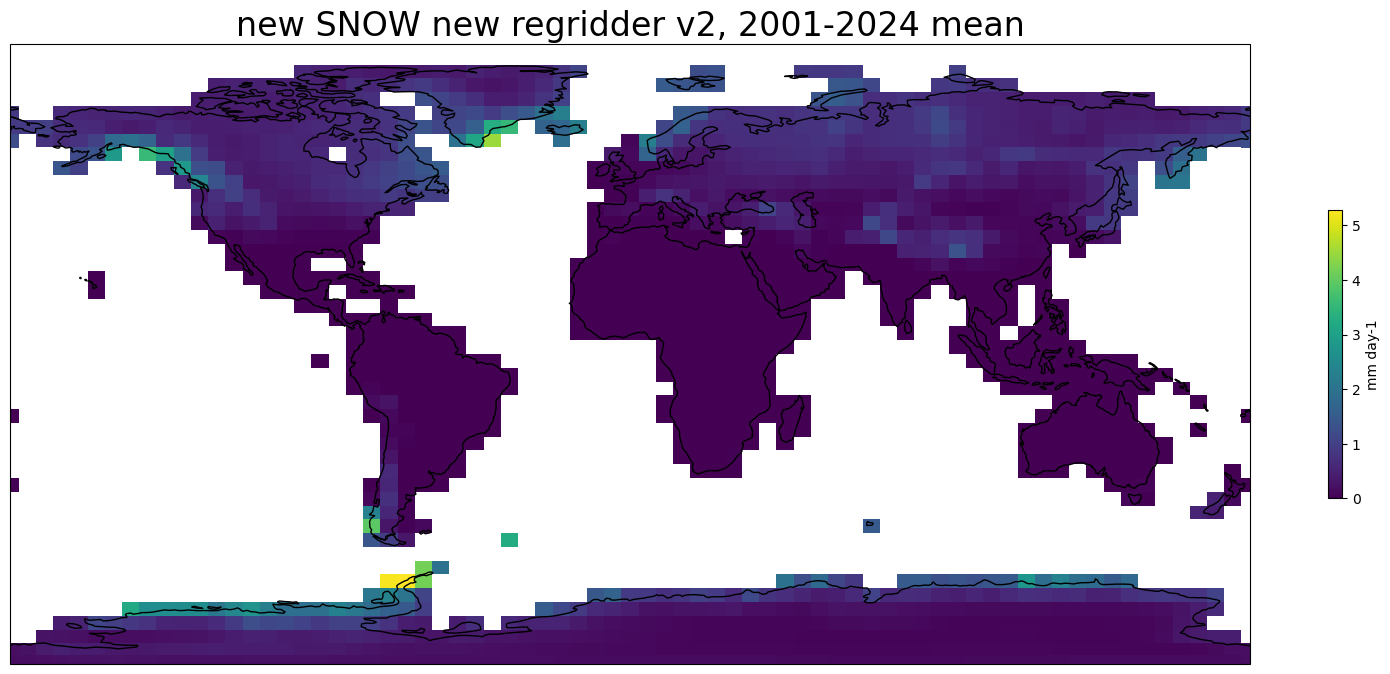

In [36]:
fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data=(SNOW4x5['SNOW']).mean('time')

C = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())
# C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15,label='mm day-1')
plt.title('new SNOW new regridder v2, 2001-2024 mean',fontsize=24)

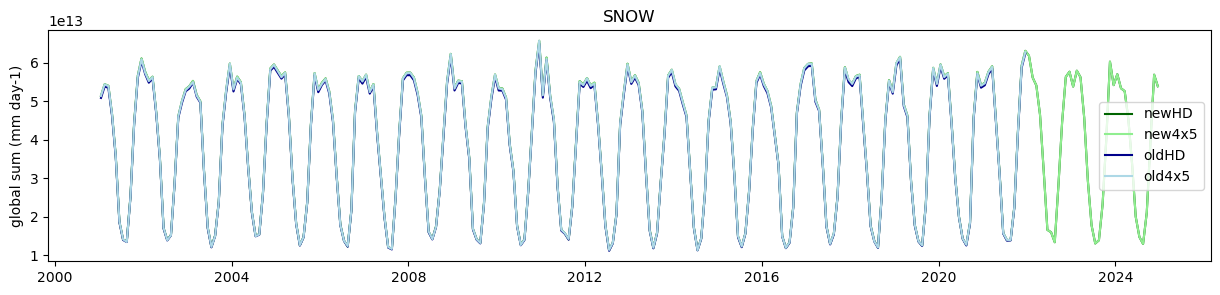

In [72]:
plt.figure(figsize=(15,3))
old_snow=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_SNOW_2001-2021.nc')
old_snow4x5=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/SNOW.nc')
plt.plot(SNOW.time,(SNOW.SNOW*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='newHD',color='darkgreen')
plt.plot(SNOW4x5.time,(SNOW4x5.SNOW*SNOW4x5.contributing_area_SNOW).sum('latitude').sum('longitude'),label='new4x5',color='lightgreen')
plt.plot(old_snow.time,(old_snow.SNOW*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='oldHD',color='darkblue')
plt.plot(old_snow.time,(old_snow4x5.SNOW*SNOW4x5.contributing_area_SNOW).sum('latitude').sum('longitude'),label='old4x5',color='lightblue')
plt.title('SNOW')
plt.ylabel('global sum (mm day-1)')
plt.legend()

In [38]:
SNOW4x5.to_netcdf('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/ERA5_4x5SNOW_2001-2024.nc')

# VPD

In [39]:
VPD=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_VPD_2001-2024.nc').transpose('latitude','longitude','time')

In [108]:
VPD4x5=regridding05x05to4x5(VPD.VPD)

Mass conservation checks: 
HD mass computed=6.367311959418424e+17
4x5 mass=6.367311959418424e+17


Text(0.5, 1.0, 'new VPD new regridder v2, 2001-2024 mean')

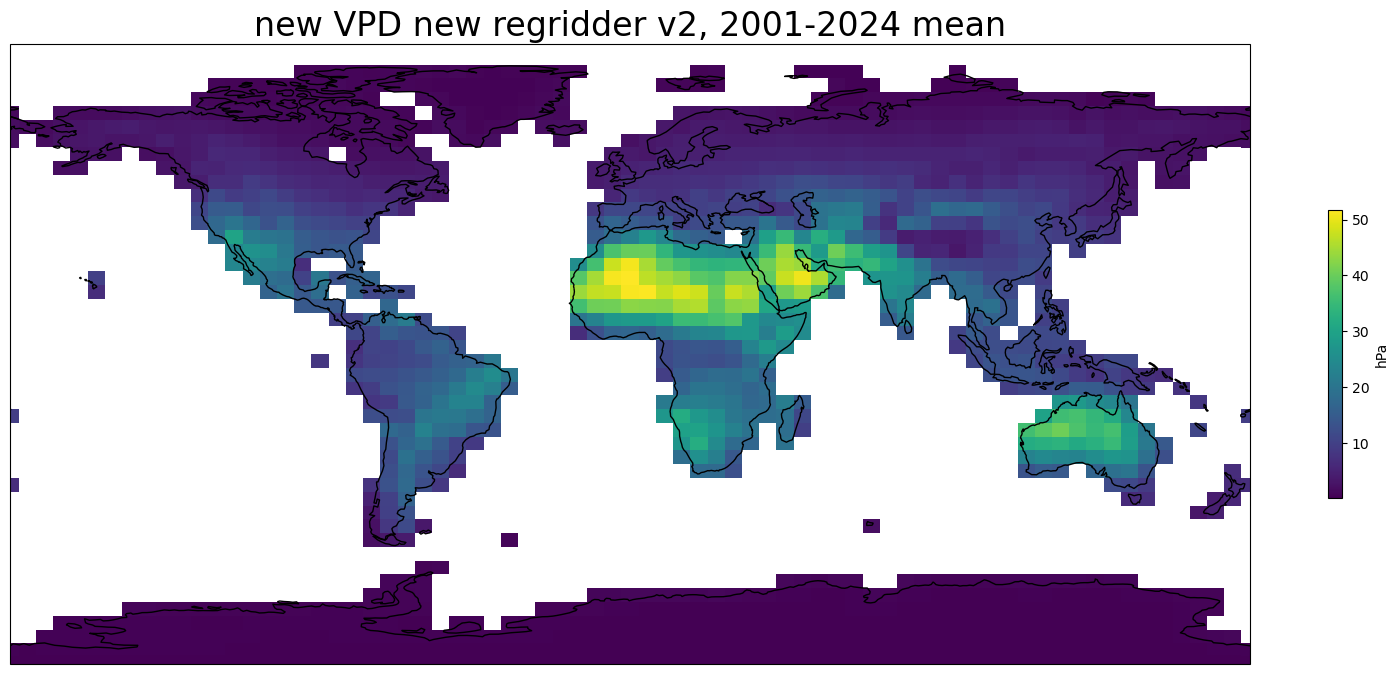

In [42]:
fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data=(VPD4x5['VPD']).mean('time')

C = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())
# C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15,label='hPa')
plt.title('new VPD new regridder v2, 2001-2024 mean',fontsize=24)

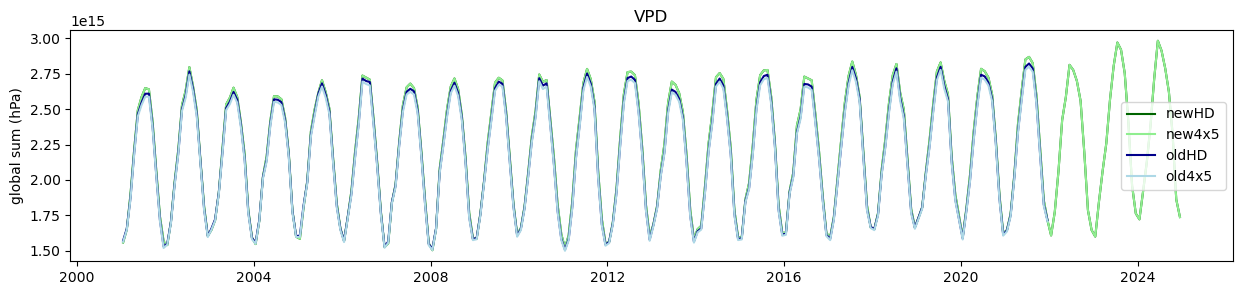

In [73]:
plt.figure(figsize=(15,3))
old_vpd=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_VPD_2001-2021.nc')
old_vpd4x5=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/VPD.nc')
plt.plot(VPD.time,(VPD.VPD*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='newHD',color='darkgreen')
plt.plot(VPD4x5.time,(VPD4x5.VPD*VPD4x5.contributing_area_VPD).sum('latitude').sum('longitude'),label='new4x5',color='lightgreen')
plt.plot(old_vpd.time,(old_vpd.VPD*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='oldHD',color='darkblue')
plt.plot(old_vpd.time,(old_vpd4x5.VPD*VPD4x5.contributing_area_VPD).sum('latitude').sum('longitude'),label='old4x5',color='lightblue')
plt.title('VPD')
plt.ylabel('global sum (hPa)')
plt.legend()

In [43]:
VPD4x5.to_netcdf('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/ERA5_4x5VPD_2001-2024.nc')

# SSRD

In [98]:
SSRD=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_SSRD_2001-2024.nc').transpose('latitude','longitude','time')

In [99]:
SSRD4x5=regridding05x05to4x5(SSRD.SSRD)

Mass conservation checks: 
HD mass computed=6.890056380797573e+17
4x5 mass=6.890056380797573e+17


Text(0.5, 1.0, 'new SSRD new regridder v2, 2001-2024 mean')

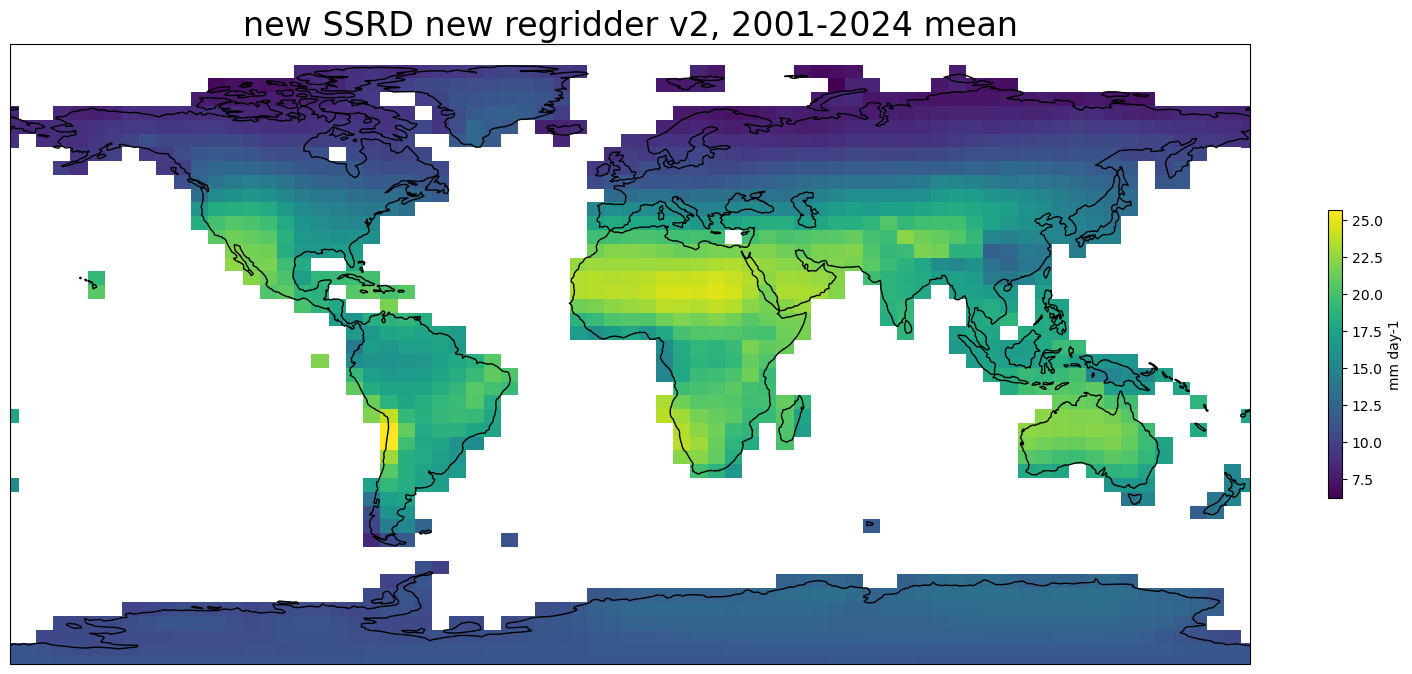

In [100]:
fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data=(SSRD4x5['SSRD']).mean('time')

C = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())
# C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15,label='mm day-1')
plt.title('new SSRD new regridder v2, 2001-2024 mean',fontsize=24)

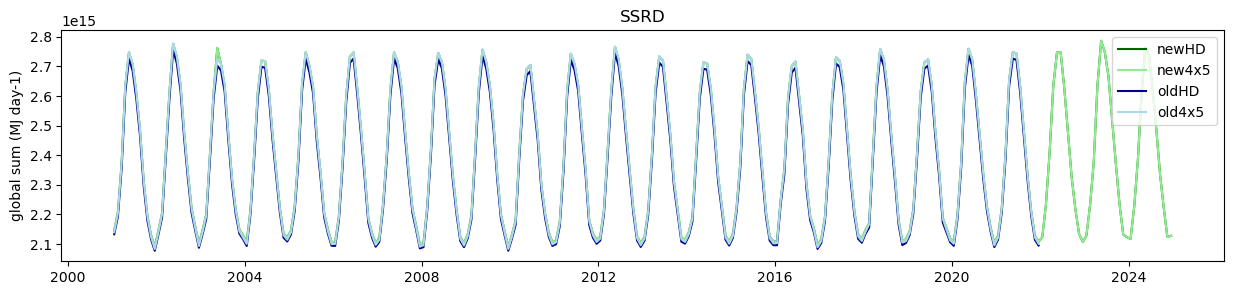

In [105]:
plt.figure(figsize=(15,3))
old_SSRD=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_SSRD_2001-2021.nc')
old_SSRD4x5=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/SSRD.nc')
plt.plot(SSRD.time,(SSRD.SSRD*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='newHD',color='darkgreen')
plt.plot(SSRD4x5.time,(SSRD4x5.SSRD*SSRD4x5.contributing_area_SSRD).sum('latitude').sum('longitude'),label='new4x5',color='lightgreen')
plt.plot(old_SSRD.time,(old_SSRD.SSRD*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='oldHD',color='darkblue')
plt.plot(old_SSRD.time,(old_SSRD4x5.SSRD*SSRD4x5.contributing_area_SSRD).sum('latitude').sum('longitude'),label='old4x5',color='lightblue')
plt.title('SSRD')
plt.ylabel('global sum (MJ day-1)')
plt.legend()

In [106]:
SSRD4x5.to_netcdf('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/ERA5_4x5SSRD_2001-2024.nc')

# STRD

In [103]:
STRD=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_STRD_2001-2021withClimatologyExtensionto2024.nc').transpose('latitude','longitude','time')

In [50]:
STRD4x5=regridding05x05to4x5(STRD.STRD)

Mass conservation checks: 
HD mass computed=1.1007593973435325e+18
4x5 mass=1.1007593973435325e+18


Text(0.5, 1.0, 'new STRD new regridder v2, 2001-2024 mean')

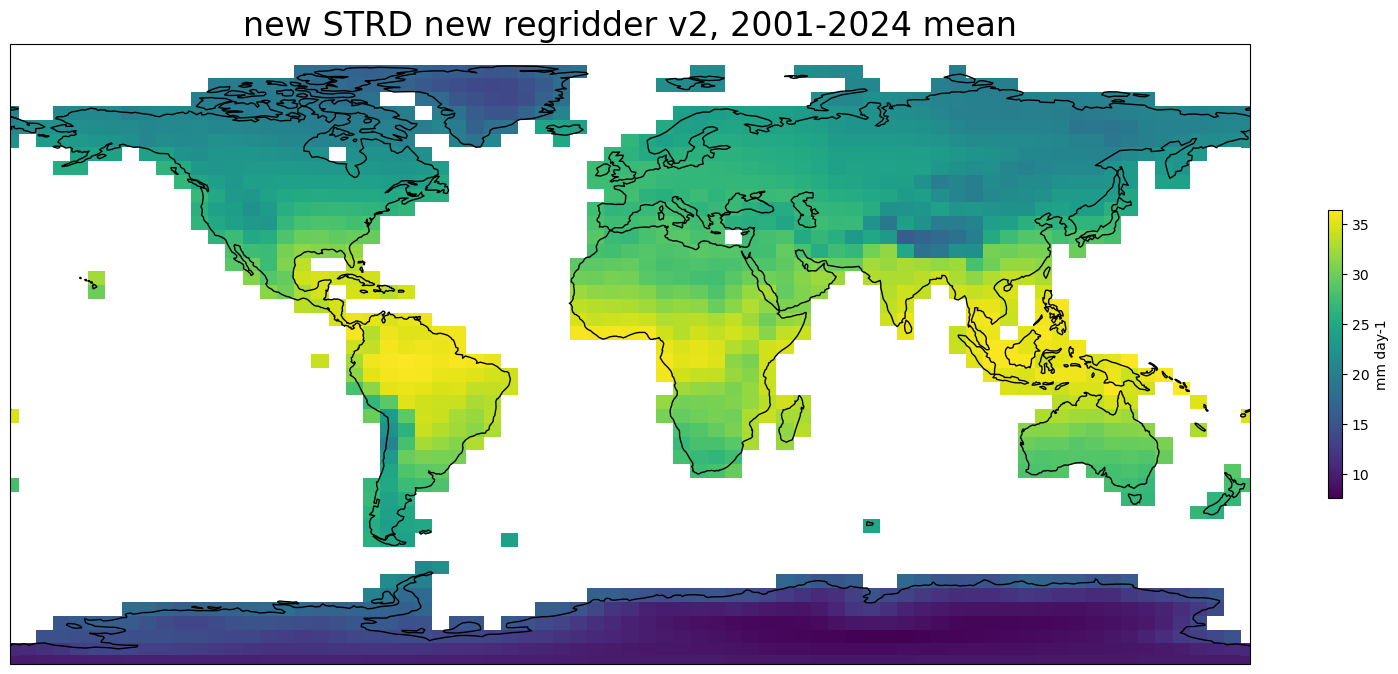

In [51]:
fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data=(STRD4x5['STRD']).mean('time')

C = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())
# C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15,label='mm day-1')
plt.title('new STRD new regridder v2, 2001-2024 mean',fontsize=24)

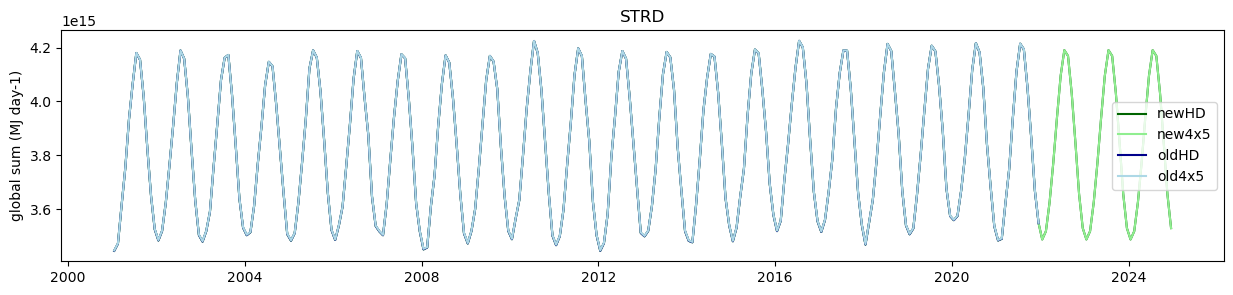

In [104]:
plt.figure(figsize=(15,3))
old_STRD=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/ERA5_STRD_2001-2021.nc')
old_STRD4x5=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/STRD.nc')
plt.plot(STRD.time,(STRD.STRD*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='newHD',color='darkgreen')
plt.plot(STRD4x5.time,(STRD4x5.STRD*STRD4x5.contributing_area_STRD).sum('latitude').sum('longitude'),label='new4x5',color='lightgreen')
plt.plot(old_STRD.time,(old_STRD.STRD*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='oldHD',color='darkblue')
plt.plot(old_STRD.time,(old_STRD4x5.STRD*STRD4x5.contributing_area_STRD).sum('latitude').sum('longitude'),label='old4x5',color='lightblue')
plt.title('STRD')
plt.ylabel('global sum (MJ day-1)')
plt.legend()

In [109]:
STRD4x5.to_netcdf('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/ERA5_4x5STRD_2001-2021withClimatologyExtensionto2024.nc')

# CO2

In [53]:
CO2=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/NOAAGML_CO2_2001-2024.nc').transpose('latitude','longitude','time')

In [54]:
CO24x5=regridding05x05to4x5(CO2.CO2)

Mass conservation checks: 
HD mass computed=1.6573590004595495e+19
4x5 mass=1.6573590004595495e+19


Text(0.5, 1.0, 'new CO2 new regridder v2, 2001-2024 mean')

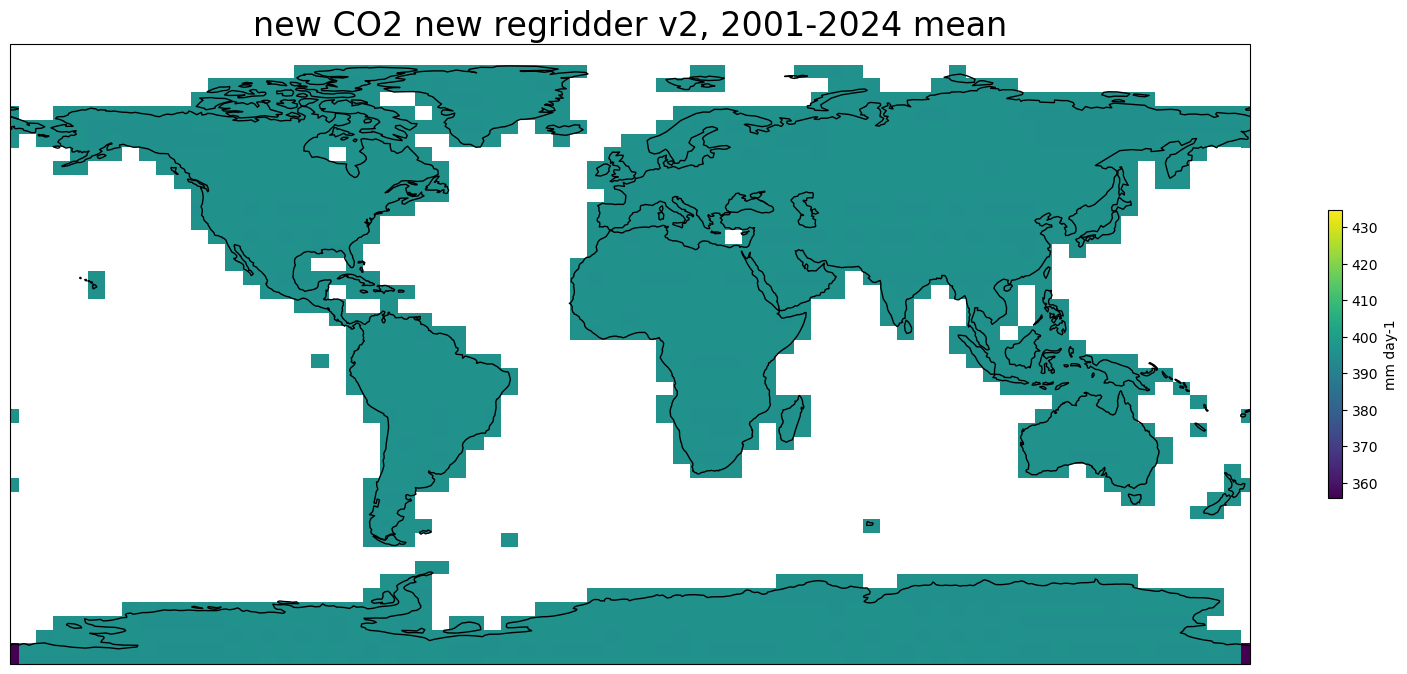

In [55]:
fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data=(CO24x5['CO2']).mean('time')

C = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())
# C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15,label='mm day-1')
plt.title('new CO2 new regridder v2, 2001-2024 mean',fontsize=24)

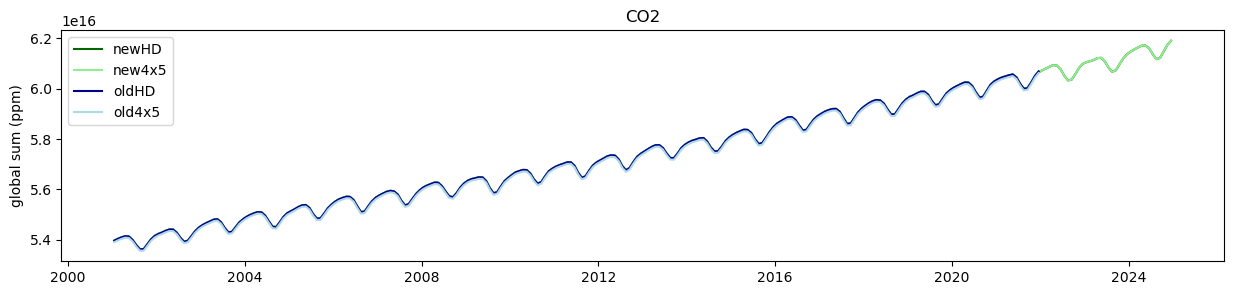

In [114]:
plt.figure(figsize=(15,3))
old_CO2=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_05x05/NOAAGML_CO2_2001-2021.nc')
old_CO24x5=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/CO2.nc')
plt.plot(CO2.time,(CO2.CO2*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='newHD',color='darkgreen')
plt.plot(CO24x5.time,(CO24x5.CO2*CO24x5.contributing_area_CO2).sum('latitude').sum('longitude'),label='new4x5',color='lightgreen')
plt.plot(old_CO2.time,(old_CO2.CO2*AreasHD2.AreasHD).sum('latitude').sum('longitude'),label='oldHD',color='darkblue')
plt.plot(old_CO2.time,(old_CO24x5.CO2*CO24x5.contributing_area_CO2).sum('latitude').sum('longitude'),label='old4x5',color='lightblue')
plt.title('CO2')
plt.ylabel('global sum (ppm)')
plt.legend()

In [115]:
CO24x5.to_netcdf('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/NOAAGML_4x5CO2_2001-2024.nc')

# Burned Area

In [131]:
BA=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/BURNED_AREA_EXTENSION_FOR_EB_JUN25.nc').transpose().rename({'lat':'latitude','lon':'longitude'})
BA_old=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/BURN.nc')

In [159]:
#Combine time series: GFED 2001-2021, GFAS 2022-2024
BA_combined=xr.full_like(CO24x5, fill_value=np.nan).rename({'CO2':'BURNED_AREA'})
BA_combined['BURNED_AREA'][dict(time=np.arange(252))]=xr.DataArray(data=BA_old.BURN.transpose('latitude','longitude','time').data,dims=['latitude','longitude','time'])
BA_combined['BURNED_AREA'][dict(time=np.arange(252,288))]=xr.DataArray(data=BA.BURNED_AREA[dict(time=np.arange(228,264))].data,dims=['latitude','longitude','time'])

Text(0.5, 1.0, 'new BA: GFED 2001-2021, GFAS 2022-2024, time mean')

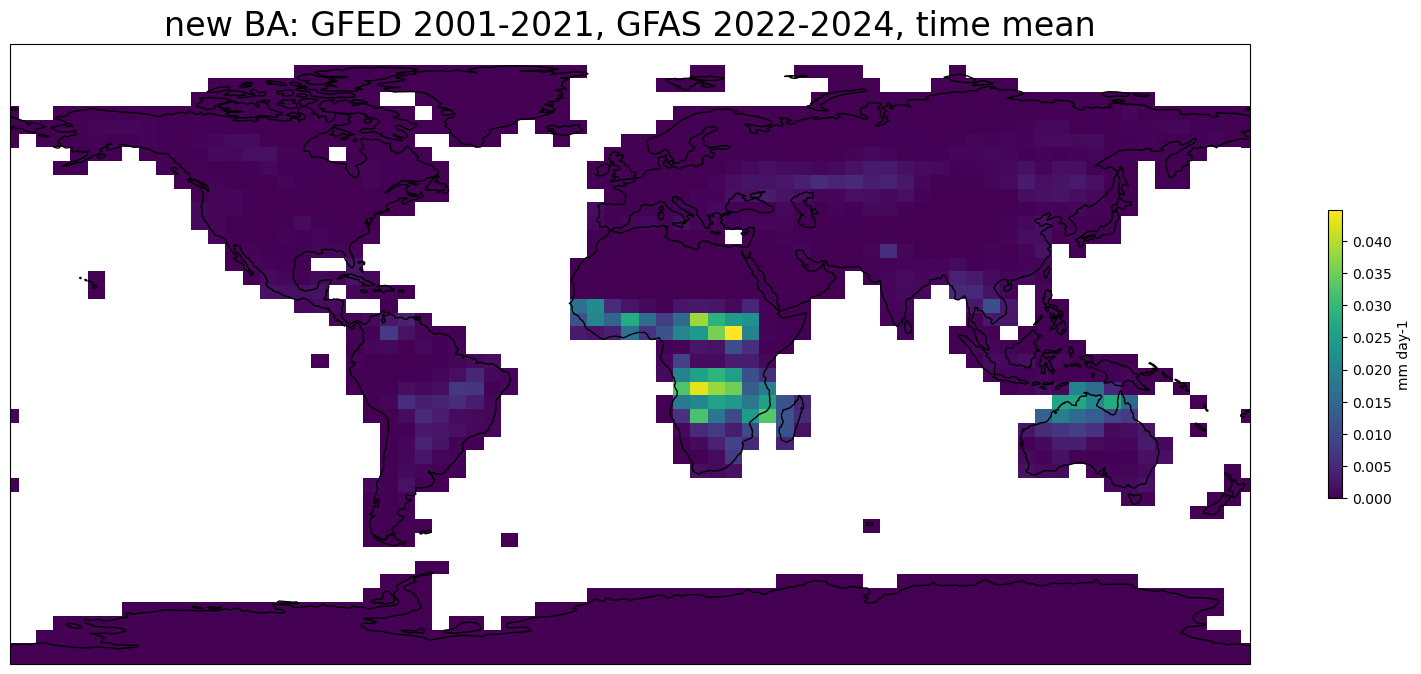

In [169]:
fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data=(BA_combined['BURNED_AREA']).mean('time').where(~np.isnan(SSRD4x5.SSRD.mean('time')))

C = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())
# C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15,label='mm day-1')
plt.title('new BA: GFED 2001-2021, GFAS 2022-2024, time mean',fontsize=24)

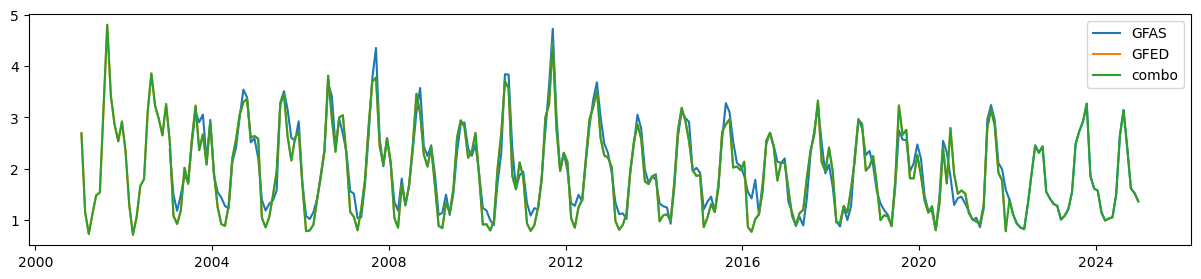

In [165]:
plt.figure(figsize=(15,3))
plt.plot(CO2.time[24:],BA.BURNED_AREA.sum('latitude').sum('longitude'),label='GFAS')
plt.plot(CO2.time[:-36],BA_old.BURN.sum('latitude').sum('longitude'),label='GFED')
plt.plot(CO2.time,BA_combined['BURNED_AREA'].sum('latitude').sum('longitude'),label='combo')
plt.legend()

In [166]:
BA_combined.to_netcdf('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/BURNED_AREA_GFED_2001-2021plusGFAS2022-2024.nc')

# Forest disturbance 

In [214]:
DIST=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/Yang_forestdisturbance_newvars_4x5_252monthly.nc')

landfrac4x5=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/CARDAMOM-MAPS_GC4x5_LAND_SEA_FRAC.nc')

#get Area of grid cell at given latitude: follow formula from GEOSChem_xygrids
Areas=(111111.111**2)*(4*5)*np.cos(landfrac4x5.latitude*pi/180)

#Add full grid cell area to arrays:
landfrac4x5['PixArea']=xr.DataArray(np.repeat(Areas.data,72).reshape(46, 72),
                          coords={'latitude':landfrac4x5.latitude.data,'longitude':landfrac4x5.longitude.data,},dims=['latitude','longitude'])


landfrac4x5['LandArea']=landfrac4x5['PixArea']*landfrac4x5['data']

DIST

# DIST['latitude']=Landfrac.latitude
# DIST['longitude']=Landfrac.longitude

<xarray.Dataset> Size: 40MB
Dimensions:              (time: 252, longitude: 72, latitude: 46)
Dimensions without coordinates: time, longitude, latitude
Data variables:
    Nonfire_disturbance  (time, longitude, latitude) float64 7MB -0.0 ... 0.0
    Fire_disturbance     (time, longitude, latitude) float64 7MB -0.0 ... 0.0
    Fire_Forest          (time, longitude, latitude) float64 7MB -0.0 ... 0.0
    Fire_Nonforest       (time, longitude, latitude) float64 7MB -0.0 ... 0.0
    Deforestation        (time, longitude, latitude) float64 7MB -0.0 ... 0.0
    Degradation          (time, longitude, latitude) float64 7MB -0.0 ... 0.0

In [216]:
# plt.imshow((DIST.nonfire_disturbance).sum('time').where(DIST.latitude>30),origin='lower')
(DIST*landfrac4x5['LandArea']).sum('latitude').sum('longitude').sum('time')/1e15
# DIST.Nonfire_disturbance.transpose('latitude','longitude','time')

<xarray.Dataset> Size: 48B
Dimensions:              ()
Data variables:
    Nonfire_disturbance  float64 8B 36.86
    Fire_disturbance     float64 8B 149.3
    Fire_Forest          float64 8B 45.59
    Fire_Nonforest       float64 8B 80.34
    Deforestation        float64 8B 28.29
    Degradation          float64 8B 8.223

In [1]:
#Combine time series: GFED 2001-2021, GFAS 2022-2024
DIST_extended=xr.full_like(CO24x5, fill_value=np.nan).rename({'CO2':'DISTURBANCE_FLUX'})
DIST_extended['DISTURBANCE_FLUX'][dict(time=np.arange(252))]=xr.DataArray(data=DIST.Nonfire_disturbance.transpose('latitude','longitude','time').data,dims=['latitude','longitude','time'])
DIST_extended['DISTURBANCE_FLUX'][dict(time=np.arange(252,288))]=xr.DataArray(data=DIST.Nonfire_disturbance.mean('time').expand_dims(time=36).transpose('latitude','longitude','time'),dims=['latitude','longitude','time'])

plt.figure(figsize=(15,3))


plt.plot(DIST_extended.time,DIST_extended['DISTURBANCE_FLUX'].sum('latitude').sum('longitude'),label='current')
plt.plot(DIST_extended.time[:252],DIST_extended['DISTURBANCE_FLUX'][dict(time=np.arange(252))].sum('latitude').sum('longitude'),label='previous')
plt.plot(DIST_extended.time[:252],DIST.Nonfire_disturbance.sum('latitude').sum('longitude'),label='previous0')

# plt.legend()


NameError: name 'xr' is not defined

# Combine everything

In [227]:
All4x5_extededMET=CO24x5.copy(deep=True).rename({'contributing_area_CO2':'contributing_area_newERA5'}) #CO2 in place
All4x5_extededMET['CO2'].attrs['units']='ppm'
All4x5_extededMET['CO2'].attrs['SOURCE']='NOAA GML'
All4x5_extededMET['contributing_area_STRD']=STRD4x5.contributing_area_STRD

All4x5_extededMET['BURNED_AREA']=BA_combined.BURNED_AREA #BA in place
All4x5_extededMET['BURNED_AREA'].attrs['units']='m2 m-2'
All4x5_extededMET['BURNED_AREA'].attrs['SOURCE']='2001-2021: GFED; 2022-2024: GFAS (derived from GFAS CO2 emissions, based on linear regression of 2003-2023 overlap with GFED burned area and GFAS CO2 emissions)'
    
All4x5_extededMET['STRD']=STRD4x5.STRD #STRD in place
All4x5_extededMET['STRD'].attrs['units']='MJ m-2 day-1'
All4x5_extededMET['STRD'].attrs['SOURCE']='ERA5 2001-2021; 2022-2024 are a climatology of 2001-2021'


All4x5_extededMET['SSRD']=SSRD4x5.SSRD #SSRD in place
All4x5_extededMET['SSRD'].attrs['units']='MJ m-2 day-1'
All4x5_extededMET['SSRD'].attrs['SOURCE']='ERA5 2001-2024'
# All4x5_extededMET['contributing_area_newERA5']=SSRD4x5.contributing_area_SSRD

All4x5_extededMET['VPD']=VPD4x5.VPD #VPD in place
All4x5_extededMET['VPD'].attrs['units']='hPa'
All4x5_extededMET['VPD'].attrs['SOURCE']='Derived from ERA5 T2M_MAX and Dewpoint temperature; 2001-2024'
# All4x5_extededMET['contributing_area_VPD']=VPD4x5.contributing_area_VPD

All4x5_extededMET['SNOWFALL']=SNOW4x5.SNOW #SNOW in place
All4x5_extededMET['SNOWFALL'].attrs['units']='mm day-1'
All4x5_extededMET['SNOWFALL'].attrs['SOURCE']='ERA5, 2001-2024'
# All4x5_extededMET['contributing_area_SNOW']=SNOW4x5.contributing_area_SNOW

All4x5_extededMET['SKT']=SKT4x5.SKT #SKT in place
All4x5_extededMET['SKT'].attrs['units']='deg C'
All4x5_extededMET['SKT'].attrs['SOURCE']='ERA5, 2001-2024'
# All4x5_extededMET['contributing_area_SKT']=SKT4x5.contributing_area_SKT

All4x5_extededMET['T2M_MAX']=TMAX4x5.TMAX #TMAX in place
All4x5_extededMET['T2M_MAX'].attrs['units']='deg C'
All4x5_extededMET['T2M_MAX'].attrs['SOURCE']='ERA5, 2001-2024'
# All4x5_extededMET['contributing_area_TMAX']=TMAX4x5.contributing_area_TMAX

All4x5_extededMET['T2M_MIN']=TMIN4x5.TMIN #TMIN in place
All4x5_extededMET['T2M_MIN'].attrs['units']='deg C'
All4x5_extededMET['T2M_MIN'].attrs['SOURCE']='ERA5, 2001-2024'
# All4x5_extededMET['contributing_area_TMIN']=TMIN4x5.contributing_area_TMIN

All4x5_extededMET['TOTAL_PREC']=Prec4x5.PREC #PREC in place
All4x5_extededMET['TOTAL_PREC'].attrs['units']='mm day-1'
All4x5_extededMET['TOTAL_PREC'].attrs['SOURCE']='ERA5, 2001-2024'
# All4x5_extededMET['contributing_area_PREC']=Prec4x5.contributing_area_PREC

All4x5_extededMET['DISTURBANCE_FLUX']=DIST_extended.DISTURBANCE_FLUX #PREC in place
All4x5_extededMET['DISTURBANCE_FLUX'].attrs['units']='gC month-1'
All4x5_extededMET['DISTURBANCE_FLUX'].attrs['SOURCE']='2001-2019: Xu et al 2021; 2020-2024: time series mean'

All4x5_extededMET



<xarray.Dataset> Size: 84MB
Dimensions:                    (latitude: 46, longitude: 72, time: 288)
Coordinates:
  * latitude                   (latitude) float64 368B -89.0 -86.0 ... 86.0 89.0
  * longitude                  (longitude) int64 576B -180 -175 -170 ... 170 175
  * time                       (time) datetime64[ns] 2kB 2001-01-16T05:15:00 ...
Data variables: (12/13)
    CO2                        (latitude, longitude, time) float64 8MB 370.7 ...
    contributing_area_newERA5  (latitude, longitude) float64 26kB 2.158e+09 ....
    contributing_area_STRD     (latitude, longitude) float64 26kB 2.158e+09 ....
    BURNED_AREA                (latitude, longitude, time) float64 8MB -0.0 ....
    STRD                       (latitude, longitude, time) float64 8MB 11.41 ...
    SSRD                       (latitude, longitude, time) float64 8MB 33.0 ....
    ...                         ...
    SNOWFALL                   (latitude, longitude, time) float64 8MB 0.1189...
    SKT                        (latitude, longitude, time) float64 8MB -31.18...
    T2M_MAX                    (latitude, longitude, time) float64 8MB -28.19...
    T2M_MIN                    (latitude, longitude, time) float64 8MB -29.37...
    TOTAL_PREC                 (latitude, longitude, time) float64 8MB 0.1191...
    DISTURBANCE_FLUX           (latitude, longitude, time) float64 8MB -0.0 ....

In [228]:
All4x5_extededMET.to_netcdf('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/All4x5Met2001-2024.nc')